In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import entropy
import copy
import pandas as pd
import math


In [80]:
def getTrainingData(songStrings,nrOfSongs):
    notes=list("ABCDEFGH")
    chord=[[0],
           [1],
           [2],
           [3],
           [4],
           [5],
           [6],
           [7]]
    source=[]
    target=[]
    song=[]
    for s in range(nrOfSongs):
        for i in range(42):
            sentence=[]
            answer=[]
            song.append(s)
            for j in range(41):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return numpy.array(source),numpy.array(target),numpy.array(song)

songStrings = numpy.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

I,O,S=getTrainingData(songStrings,2)
print(I.shape,O.shape,S.shape)

(84, 41) (84, 41) (84,)


In [81]:
len(songStrings[0])

42

In [82]:
S

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [83]:
I.shape

(84, 41)

In [19]:
print(I[0].flatten(),O[0].flatten())
print(I[1].flatten(),O[1].flatten())
print(I[2].flatten(),O[2].flatten())

print(I[-2].flatten(),O[-2].flatten())
print(I[-1].flatten(),O[-1].flatten())

[2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3] [2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2]
[2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2] [6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2]
[6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2] [6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3
 3 2 2 2]
[3 2 2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6
 5 5 4 4] [2 2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5
 5 4 4 3]
[2 2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5
 5 4 4 3] [2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3]


In [20]:
import numpy as np

def getTrainingData(songStrings, nrOfSongs):
    notes = list("ABCDEFGH")
    nrOfNotes = len(songStrings[0])  # Assuming all songs are the same length
    source = []
    target = []
    song = []
    
    for s in range(nrOfSongs):
        indices = [notes.index(note) for note in songStrings[s]]
        for i in range(nrOfNotes):
            # Create sequences by shifting manually
            sentence = indices[i:] + indices[:i]  # Wrap around to create circular shift
            source.append(sentence[:-1])  # Exclude the last to form the source sequence
            target.append(sentence[1:])   # Start from the second element to form the target sequence
            song.append(s)
    
    return np.array(source), np.array(target), np.array(song)

# Convert songStrings to a NumPy array for efficient indexing
songStrings = np.array([
    #"CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

I, O, S = getTrainingData(songStrings, 1)
print(I.shape, O.shape, S.shape)


(42, 41) (42, 41) (42,)


In [21]:
print(I[0].flatten(),O[0].flatten())
print(I[1].flatten(),O[1].flatten())
print(I[2].flatten(),O[2].flatten())
print(I[3].flatten(),O[3].flatten())
print(I[4].flatten(),O[4].flatten())

print(I[-4].flatten(),O[-4].flatten())
print(I[-3].flatten(),O[-3].flatten())
print(I[-2].flatten(),O[-2].flatten())
print(I[-1].flatten(),O[-1].flatten())

[0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 3 4] [1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5]
[1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5] [2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0]
[2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0] [3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1]
[3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1] [4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4
 5 0 1 2]
[4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4
 5 0 1 2] [5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5
 0 1 2 3]
[2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0] [3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 

In [22]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, emsize, nhead, d_hid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emsize, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntokens, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, ntokens)
        self.ntokens=ntokens
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,verbose=False):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        self.store=output.detach().numpy().copy()
        if verbose:
            print(output.shape)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [26]:
def test(model, source, target):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        
        # The output is [sequence_length, batch_size, ntokens]. Get the most likely token predictions
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability
        #print(predictions)
        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions
        
    accuracy = correct / total  # Calculate the accuracy
    return accuracy

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/2966603154.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/2966603154.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)
/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/1989781991.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/87/pnb9p7

Epoch 1, Loss: 0.0124
acc: 0.16855400696864112
Epoch 101, Loss: 0.0087
acc: 0.47343205574912894
Epoch 201, Loss: 0.0061
acc: 0.6009001161440186
Epoch 301, Loss: 0.0030
acc: 0.8297038327526133
Epoch 401, Loss: 0.0014
acc: 0.9322009291521487
Epoch 501, Loss: 0.0010
acc: 0.9538327526132404
Epoch 601, Loss: 0.0007
acc: 0.9618176538908246
Epoch 701, Loss: 0.0006
acc: 0.9657375145180023
Epoch 801, Loss: 0.0006
acc: 0.9679152148664344
Epoch 901, Loss: 0.0005
acc: 0.9690766550522648
Epoch 1001, Loss: 0.0005
acc: 0.9699477351916377
Epoch 1101, Loss: 0.0005
acc: 0.9700929152148664


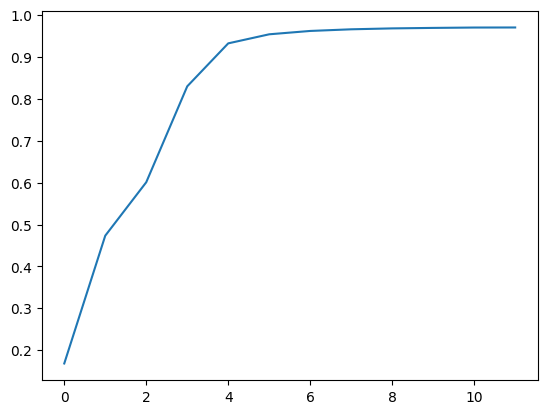

In [27]:
def train(model, source, target, num_epochs=1000, learning_rate=1e-3):
    W=[]
    model.train()  # Set the model to training mode
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Assuming source and target are numpy arrays of shape (sentences, 41) and need to be converted to tensors
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        # Here, we assume batching is handled externally, and source is directly fed into the model
        optimizer.zero_grad()  # Clear the gradients of all optimized tensors
        
        # Adjust for PyTorch expecting (sequence_length, batch_size), so we transpose source and target
        src = source.transpose(0, 1)  # Now shape [41, sentences]
        tgt = target.transpose(0, 1)  # Now shape [41, sentences]
        
        output = model(src)  # Forward pass: compute the output of the model
        
        # Output is [sequence_length, batch_size, ntokens], target is [sequence_length, batch_size]
        # Flatten output to [sequence_length*batch_size, ntokens] for compatibility with CrossEntropyLoss
        output_flat = output.view(-1, model.ntokens)
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(output_flat, tgt_flat)  # Compute the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        
        total_loss += loss.item()
        
        avg_loss = total_loss / src.size(1)  # average loss per sentence
        if epoch % 100 ==0:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            W.append(test(model,source,target))
            print("acc:",W[-1])
        if  W[-1]>0.97:
            break    
    return W
# Example usage
# Assuming `model` is your model instance, and `source`, `target` are your data tensors

ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.00  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

nrOfSongs=4
source,target,songs=getTrainingData(songStrings,nrOfSongs)

W=train(model, torch.tensor(source), torch.tensor(target),num_epochs=5000)
plot(W)

In [240]:
source,target,songs=getTrainingData(songStrings,1)


In [241]:
source.shape

(42, 41)

In [29]:
test(model,torch.tensor(source),torch.tensor(target))

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/1989781991.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/1989781991.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


0.9700929152148664

In [30]:
def predict_next_token(model, token_indices,verbose=False):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Convert the list of token indices to a PyTorch tensor and add a batch dimension
    src = torch.tensor(token_indices, dtype=torch.long).unsqueeze(1)  # Shape [sequence_length, 1] to match expected input

    with torch.no_grad():
        output = model(src,verbose)  # Get model output for the entire sequence

    # Assuming output is [sequence_length, 1, ntokens] and we're interested in the last token's prediction
    last_token_logits = output[-1, 0, :]  # Get logits for the last token
    predicted_token_index = last_token_logits.argmax().item()  # Find the index of the max log-probability
    
    return predicted_token_index

# Example usage:
# Assuming you have a `model` instance and a sentence represented as a list of token indices
# token_indices = [1, 2, 3, 2, 1, 2, 3, ...]
who=34
predicted_token_index = predict_next_token(model, source[who],verbose=True)
print(f'Predicted next token index: {predicted_token_index}')
print(target[who][-1])

torch.Size([41, 1, 20])
Predicted next token index: 3
3


In [31]:
    for i in range(len(songs)):
        print(i,songs[i])
        print("source",source[i])


0 0
source [0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 3 4]
1 0
source [1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5]
2 0
source [2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0]
3 0
source [3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1]
4 0
source [4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4
 5 0 1 2]
5 0
source [5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5
 0 1 2 3]
6 0
source [0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 3 4]
7 0
source [1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5]
8 0
source [2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0]
9 0
source [3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1]
10 0
source [4 5 0 1 2 3 4 5 0 1 2 3 4 5

(20, 168)
(20, 168)


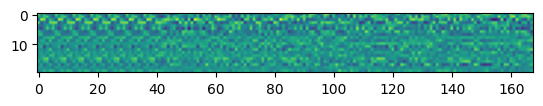

In [32]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def getAllIOH(model,source,target,songs,width=20):
    I=[]
    O=[]
    H=[]
    for i in range(len(songs)):
        I.append(songs[i])
        predicted_token_index = predict_next_token(model, source[i])
        if predicted_token_index==target[i][-1]:
            O.append(songs[i])
        else:
            O.append((songs[i]+1)%max(songs))
        H.append(list(model.store[-1].flatten()))
    H=numpy.array(H).transpose()
    print(H.shape)
    imshow(H)
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
    print(B.shape)
    H=numpy.zeros((H.shape[1]))
    for i in range(width):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return numpy.array(I),numpy.array(O),H

def shrinkingDecompositionInformation(model,source,target,songs,numbers=[0,1,2,3],width=20):
    allI,allO,H=getAllIOH(model,source,target,songs,width=width)
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=(1*(songs==number)).astype(int)
        O=(1*(allO==number)).astype(int)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

s,h=shrinkingDecompositionInformation(model,source,target,songs,numbers=list(range(5)),width=20)

In [33]:
M=removalIntoMatrix(s,20,h)

In [34]:
print(M.shape)

(5, 20)


0.7993386655816854 0.0


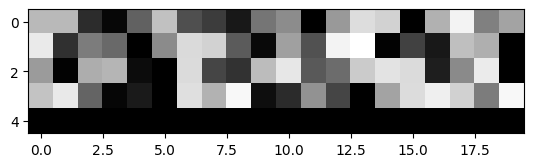

In [35]:
imshow(M,cmap="gray")
print(M.max(),M.min())

In [36]:
print(M.mean(),M.std())

0.3139788132777146 0.28518808249275135


In [37]:
print(songs)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


(20, 168)
(20, 168)


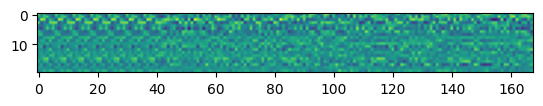

In [38]:
allI,allO,H=getAllIOH(model,source,target,songs,width=20)

In [39]:
number=5
I=(1*(songs==number)).astype(int)
O=(target.transpose()[-1]==allO)

In [40]:
allI

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [41]:
allO

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [42]:
allI

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
model.state_dict().keys()
#model.state_dict().values()

odict_keys(['pos_encoder.pe', 'transformer_encoder.layers.0.self_attn.in_proj_weight', 'transformer_encoder.layers.0.self_attn.in_proj_bias', 'transformer_encoder.layers.0.self_attn.out_proj.weight', 'transformer_encoder.layers.0.self_attn.out_proj.bias', 'transformer_encoder.layers.0.linear1.weight', 'transformer_encoder.layers.0.linear1.bias', 'transformer_encoder.layers.0.linear2.weight', 'transformer_encoder.layers.0.linear2.bias', 'transformer_encoder.layers.0.norm1.weight', 'transformer_encoder.layers.0.norm1.bias', 'transformer_encoder.layers.0.norm2.weight', 'transformer_encoder.layers.0.norm2.bias', 'transformer_encoder.layers.1.self_attn.in_proj_weight', 'transformer_encoder.layers.1.self_attn.in_proj_bias', 'transformer_encoder.layers.1.self_attn.out_proj.weight', 'transformer_encoder.layers.1.self_attn.out_proj.bias', 'transformer_encoder.layers.1.linear1.weight', 'transformer_encoder.layers.1.linear1.bias', 'transformer_encoder.layers.1.linear2.weight', 'transformer_encode

(41, 8) (41, 8)
[1. 0. 0. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0. 0.]


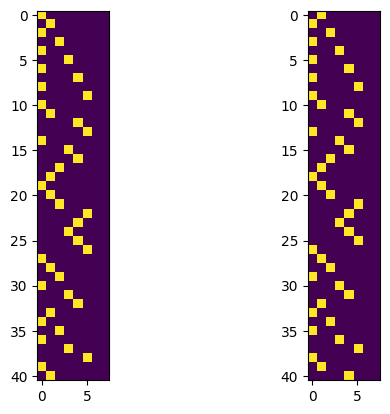

In [230]:

songStrings = numpy.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

notes=list("ABCDEFGH")


def generateIOData(songNr,songStrings=songStrings):
    I=numpy.zeros((41,8))
    O=numpy.zeros((41,8))
    for i in range(41):
        I[i][notes.index(songStrings[songNr][i])]=1.0
        O[i][notes.index(songStrings[songNr][i+1])]=1.0
    return I,O

I,O=generateIOData(2,songStrings)
print(I.shape,O.shape)
print(I[0],O[0])
subplot(1,2,1)
imshow(I)
subplot(1,2,2)
imshow(O)

In [231]:
I.shape

(41, 8)

In [232]:
O.shape

(41, 8)

In [ ]:
class SimpleRNNModel(nn.Module):
    def __init__(self):
        super(SimpleRNNModel, self).__init__()
        self.expansion_layer = nn.Linear(in_features=8, out_features=20)
        self.rnn_layer = nn.RNN(input_size=20, hidden_size=20, batch_first=True)
        self.output_layer = nn.Linear(in_features=20, out_features=8)

    def forward(self, x):
        x = torch.relu(self.expansion_layer(x))
        x, _ = self.rnn_layer(x)
        #x = torch.sigmoid(self.output_layer(x))
        x = torch.softmax(self.output_layer(x), dim=-1)
        return x
model=SimpleRNNModel()
output=model(torch.Tensor(I))
output.shape

torch.Size([41, 8])

In [ ]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(NetRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.softmax(self.outputLayer(out), dim = -1)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = torch.softmax(self.outputLayer(out),dim = -1)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


In [ ]:
model = SimpleRNNModel()
number_of_Songs = 4
songs =  list(range(number_of_Songs))

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 2000  # Number of times to iterate over the entire dataset
L = []
A = []
AccSong1 = []
AccSong2 = []
AccSong3 = []
AccSong4 = []
AccSong5 = []
for epoch in range(num_epochs):
    # Shuffle songs for each epoch
    numpy.random.shuffle(songs)
    lo=numpy.zeros((number_of_Songs))
    acc=numpy.zeros((number_of_Songs))
    for song in songs:
        # Generate input-output data for the current song
        I, O = generateIOData(song)
        
        # Convert data to tensors if not already
        inputs = torch.tensor([I], dtype=torch.float)
        targets = torch.tensor([O], dtype=torch.float) # Assuming O is one-hot encoded and targets are needed for CrossEntropyLoss
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, targets)  # Reshape to match [batch_size*sequence_length, num_classes]
        
        _, predicted_indices = torch.max(outputs, 2)  # Get indices of max values across the last dimension
        _, true_indices = torch.max(torch.tensor(O, dtype=torch.float), 1)  # Get true indices for comparison

        # Calculate accuracy
        correct_predictions = (predicted_indices.squeeze() == true_indices).float().sum()  # Squeeze to remove batch dim
        accuracy = correct_predictions / O.shape[0]
        acc[song]=accuracy.item()
        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo[song]=loss.item()

    if epoch%10==0: 
        print(f'Epoch {epoch+1}, Loss: {mean(lo)}, Losses: {numpy.round(lo,3)}')
        print(f'Epoch {epoch+1}, Accuracy: {mean(acc)}, Accuracies: {numpy.round(acc,3)}')
    L.append(mean(lo))
    A.append(mean(acc))
    AccSong1.append(acc[0])
    AccSong2.append(acc[1])
    AccSong3.append(acc[2])
    AccSong4.append(acc[3])
    AccSong5.append(acc[4])




Epoch 1, Loss: 19.032355117797852, Losses: [19.033 19.033 19.032 19.032 19.031]
Epoch 1, Accuracy: 0.14146340936422347, Accuracies: [0.098 0.146 0.293 0.073 0.098]
Epoch 11, Loss: 19.028186416625978, Losses: [19.031 19.024 19.028 19.03  19.029]
Epoch 11, Accuracy: 0.13658536672592164, Accuracies: [0.268 0.146 0.171 0.024 0.073]
Epoch 21, Loss: 19.016604614257812, Losses: [19.025 18.99  19.019 19.025 19.024]
Epoch 21, Accuracy: 0.04878048896789551, Accuracies: [0.244 0.    0.    0.    0.   ]
Epoch 31, Loss: 18.997301483154295, Losses: [19.011 18.947 19.    19.016 19.013]
Epoch 31, Accuracy: 0.09756097495555878, Accuracies: [0.244 0.146 0.049 0.024 0.024]
Epoch 41, Loss: 18.97298927307129, Losses: [18.99  18.898 18.982 19.002 18.993]
Epoch 41, Accuracy: 0.1902438998222351, Accuracies: [0.195 0.463 0.146 0.049 0.098]
Epoch 51, Loss: 18.944991302490234, Losses: [18.97  18.85  18.957 18.985 18.964]
Epoch 51, Accuracy: 0.37073170244693754, Accuracies: [0.317 0.683 0.39  0.171 0.293]
Epoch 61

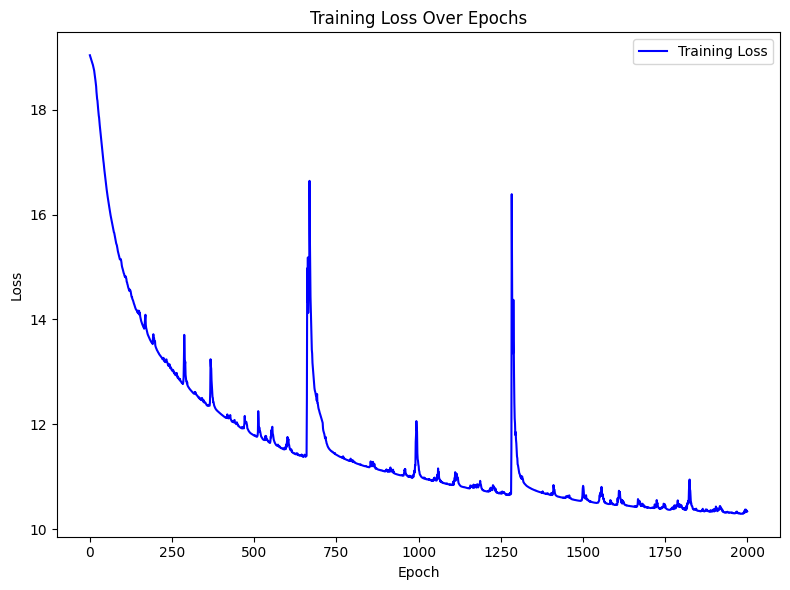

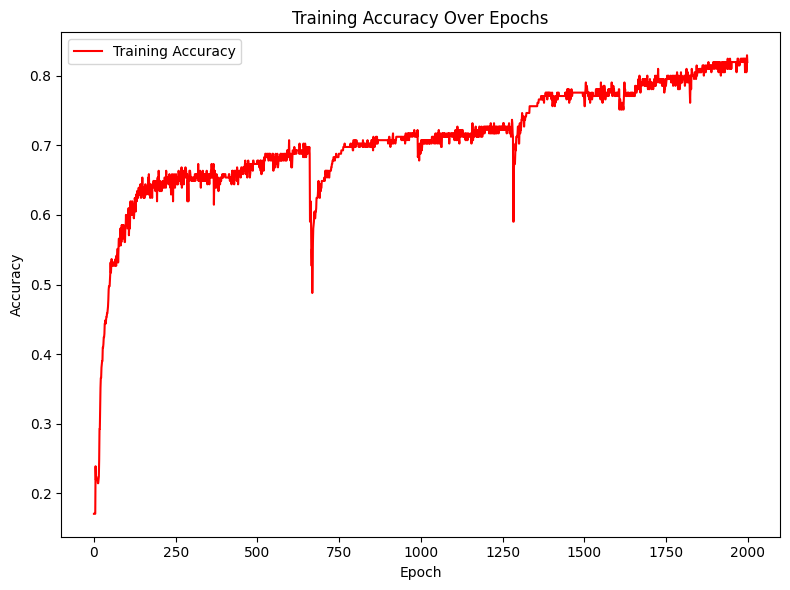

In [ ]:
# Plot for Loss
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(L, label='Training Loss', color='blue')  # Plot loss with a label
plt.title('Training Loss Over Epochs')  # Title of the plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.grid(False)  # Add grid lines for better readability
plt.legend()  # Show legend to identify the line plot
plt.tight_layout()  # Adjust the layout to make room for the elements
plt.show()  # Display the plot

# Plot for Accuracy
plt.figure(figsize=(8, 6))  # Set figure size for the accuracy plot
plt.plot(A, label='Training Accuracy', color='red')  # Plot accuracy with a label
plt.title('Training Accuracy Over Epochs')  # Title of the plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.grid(False)  # Add grid lines for better readability
plt.legend()  # Show legend
plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plot

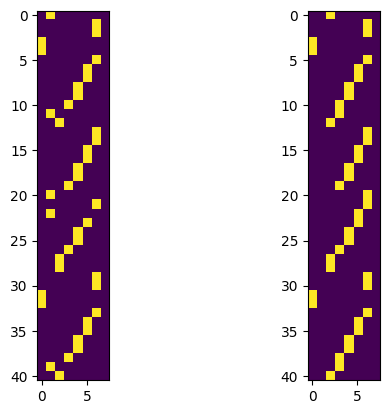

In [ ]:
subplot(1,2,1)
imshow(outputs.detach().numpy()[0])
subplot(1,2,2)
imshow(targets[0])

In [ ]:
def calculate_accuracy(model, songStrings, songNr):
    # Prepare the data for the specified song
    I, O = generateIOData(songNr)
    
    # Convert input to tensor and get model predictions
    inputs = torch.tensor(I, dtype=torch.float).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        outputs = model(inputs)
    
    # Convert outputs to predicted indices
    _, predicted_indices = torch.max(outputs, 2)  # Get indices of max values across the last dimension
    _, true_indices = torch.max(torch.tensor(O, dtype=torch.float), 1)  # Get true indices for comparison

    # Calculate accuracy
    correct_predictions = (predicted_indices.squeeze() == true_indices).float().sum()  # Squeeze to remove batch dim
    accuracy = correct_predictions / O.shape[0]
    
    return accuracy.item()

# Example usage:
accuracy = calculate_accuracy(model, songStrings, 0)
print(f'Accuracy: {accuracy}')


Accuracy: 0.8780487775802612


In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [ ]:
class RNNA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(RNNA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp)  

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        
        attn_out = self.attention(x)
        
        expanded_attn_out = self.expand_layer(attn_out)
        
        expanded_attn_out = torch.relu(expanded_attn_out)

        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        
        rnn_out, self.hidden = self.rnnLayer(expanded_attn_out, h0)
    
        out = torch.softmax(self.outputLayer(rnn_out),dim =-1)

        return out
    
    

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                # RNN processing
                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.softmax(self.outputLayer(out),dim = -1)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


Epoch 1, Loss: 0.11159466952085495, Losses: [0.11 0.11 0.11 0.11 0.11]
Epoch 1, Accuracy: 0.0, Accuracies: [0. 0. 0. 0. 0.]
Epoch 11, Loss: 0.10732507705688477, Losses: [0.11 0.11 0.11 0.11 0.11]
Epoch 11, Accuracy: 0.18048780262470246, Accuracies: [0.2  0.17 0.12 0.22 0.2 ]
Epoch 21, Loss: 0.10577739030122757, Losses: [0.11 0.1  0.11 0.1  0.1 ]
Epoch 21, Accuracy: 0.18048780262470246, Accuracies: [0.2  0.17 0.12 0.22 0.2 ]
Epoch 31, Loss: 0.10552455335855485, Losses: [0.11 0.1  0.11 0.1  0.1 ]
Epoch 31, Accuracy: 0.20975609719753266, Accuracies: [0.2  0.22 0.15 0.27 0.22]
Epoch 41, Loss: 0.10527340322732925, Losses: [0.11 0.1  0.11 0.1  0.1 ]
Epoch 41, Accuracy: 0.2243902415037155, Accuracies: [0.2  0.22 0.17 0.29 0.24]
Epoch 51, Loss: 0.10496162921190262, Losses: [0.11 0.1  0.1  0.1  0.1 ]
Epoch 51, Accuracy: 0.2243902415037155, Accuracies: [0.2  0.2  0.17 0.32 0.24]
Epoch 61, Loss: 0.10447776168584824, Losses: [0.11 0.1  0.1  0.1  0.1 ]
Epoch 61, Accuracy: 0.21951219141483308, Accur

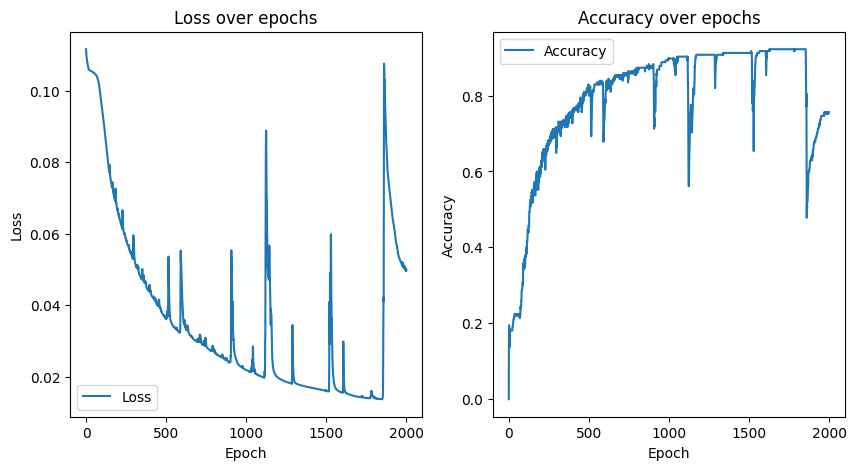

In [ ]:
model = RNNA()
number_of_Songs = 4
songs =  list(range(number_of_Songs))

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 2000  # Number of times to iterate over the entire dataset
L = []
A = []
for epoch in range(num_epochs):
    # Shuffle songs for each epoch
    numpy.random.shuffle(songs)
    lo=numpy.zeros((number_of_Songs))
    acc=numpy.zeros((number_of_Songs))
    for song in songs:
        # Generate input-output data for the current song
        I, O = generateIOData(song)
        
        # Convert data to tensors if not already
        inputs = torch.tensor([I], dtype=torch.float)
        targets = torch.tensor([O], dtype=torch.float) # Assuming O is one-hot encoded and targets are needed for CrossEntropyLoss
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, targets)  # Reshape to match [batch_size*sequence_length, num_classes]
        
        _, predicted_indices = torch.max(outputs, 2)  # Get indices of max values across the last dimension
        _, true_indices = torch.max(torch.tensor(O, dtype=torch.float), 1)  # Get true indices for comparison

        # Calculate accuracy
        correct_predictions = (predicted_indices.squeeze() == true_indices).float().sum()  # Squeeze to remove batch dim
        accuracy = correct_predictions / O.shape[0]
        acc[song]=accuracy.item()
        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo[song]=loss.item()

    if epoch%10==0: 
        print(f'Epoch {epoch+1}, Loss: {mean(lo)}, Losses: {numpy.round(lo,2)}')
        print(f'Epoch {epoch+1}, Accuracy: {mean(acc)}, Accuracies: {numpy.round(acc,2)}')
    L.append(mean(lo))
    A.append(mean(acc))



# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(L, label='Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(A, label='Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
        

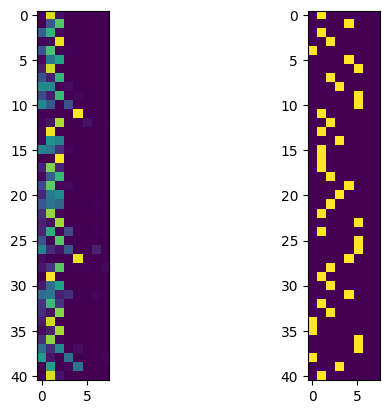

In [ ]:
subplot(1,2,1)
imshow(outputs.detach().numpy()[0])
subplot(1,2,2)
imshow(targets[0])        

In [ ]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        self.outputLayer = nn.Linear(int(self.hidden_dim/2), self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)), torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        out, self.h0 = self.lstmLayer(x, self.h0)
        #out = torch.tanh(out)  # Apply tanh to the LSTM output if needed

        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)

        out = torch.softmax(self.outputLayer(out),dim = -1)
        return out

        
    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = torch.softmax(self.outputLayer(out),dim = -1)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    


Epoch 1, Loss: 0.11064083725214005, Losses: [0.11 0.11 0.11 0.11 0.11]
Epoch 1, Accuracy: 0.024390244483947755, Accuracies: [0.   0.   0.   0.   0.12]
Epoch 11, Loss: 0.10823198258876801, Losses: [0.11 0.11 0.11 0.11 0.11]
Epoch 11, Accuracy: 0.18048780262470246, Accuracies: [0.2  0.17 0.12 0.22 0.2 ]
Epoch 21, Loss: 0.10686821937561035, Losses: [0.11 0.11 0.11 0.11 0.11]
Epoch 21, Accuracy: 0.18048780262470246, Accuracies: [0.2  0.17 0.12 0.22 0.2 ]
Epoch 31, Loss: 0.10587545037269593, Losses: [0.11 0.1  0.11 0.1  0.11]
Epoch 31, Accuracy: 0.18048780262470246, Accuracies: [0.2  0.17 0.12 0.22 0.2 ]
Epoch 41, Loss: 0.10506255477666855, Losses: [0.11 0.1  0.11 0.1  0.1 ]
Epoch 41, Accuracy: 0.2634146332740784, Accuracies: [0.2  0.34 0.22 0.29 0.27]
Epoch 51, Loss: 0.10390535593032837, Losses: [0.11 0.1  0.1  0.1  0.1 ]
Epoch 51, Accuracy: 0.27804877758026125, Accuracies: [0.2  0.37 0.22 0.32 0.29]
Epoch 61, Loss: 0.10204056203365326, Losses: [0.11 0.1  0.1  0.1  0.1 ]
Epoch 61, Accuracy

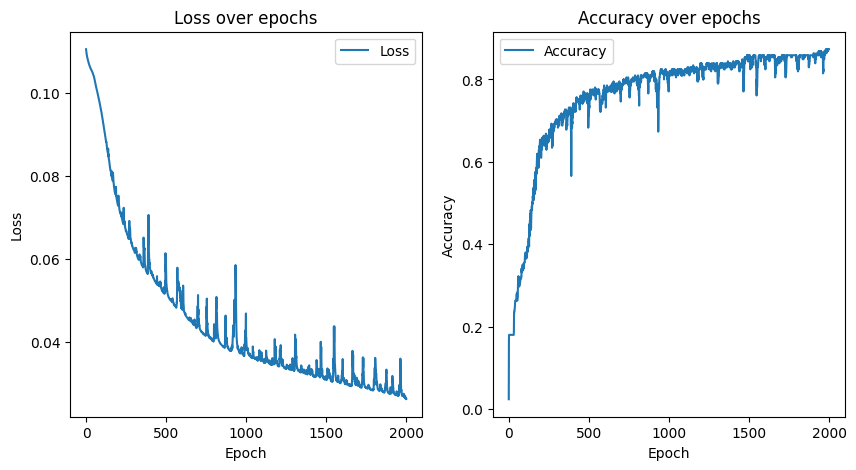

In [ ]:
model = LSTM()

songs =  list(range(4))

# Loss function and optimizer
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 2000  # Number of times to iterate over the entire dataset
L = []
A = []
for epoch in range(num_epochs):
    # Shuffle songs for each epoch
    numpy.random.shuffle(songs)
    lo=numpy.zeros((number_of_Songs))
    acc=numpy.zeros((number_of_Songs))
    for song in songs:
        # Generate input-output data for the current song
        I, O = generateIOData(song)
        
        # Convert data to tensors if not already
        inputs = torch.tensor([I], dtype=torch.float)
        targets = torch.tensor([O], dtype=torch.float) # Assuming O is one-hot encoded and targets are needed for CrossEntropyLoss
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, targets)  # Reshape to match [batch_size*sequence_length, num_classes]
        
        _, predicted_indices = torch.max(outputs, 2)  # Get indices of max values across the last dimension
        _, true_indices = torch.max(torch.tensor(O, dtype=torch.float), 1)  # Get true indices for comparison

        # Calculate accuracy
        correct_predictions = (predicted_indices.squeeze() == true_indices).float().sum()  # Squeeze to remove batch dim
        accuracy = correct_predictions / O.shape[0]
        acc[song]=accuracy.item()
        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo[song]=loss.item()

    if epoch%10==0: 
        print(f'Epoch {epoch+1}, Loss: {mean(lo)}, Losses: {numpy.round(lo,2)}')
        print(f'Epoch {epoch+1}, Accuracy: {mean(acc)}, Accuracies: {numpy.round(acc,2)}')
    L.append(mean(lo))
    A.append(mean(acc))



# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(L, label='Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(A, label='Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [57]:
class SimpleRNNModel(nn.Module):
    def __init__(self):
        super(SimpleRNNModel, self).__init__()
        self.expansion_layer = nn.Linear(in_features=8, out_features=20)
        self.rnn_layer = nn.RNN(input_size=20, hidden_size=20, batch_first=True)
        self.output_layer = nn.Linear(in_features=20, out_features=8)

    def forward(self, x):
        x = torch.relu(self.expansion_layer(x))
        x, _ = self.rnn_layer(x)
        x = self.output_layer(x)  # Removed softmax here
        return x


(41, 8) (41,)
[1. 0. 0. 0. 0. 0. 0. 0.] [1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 0]


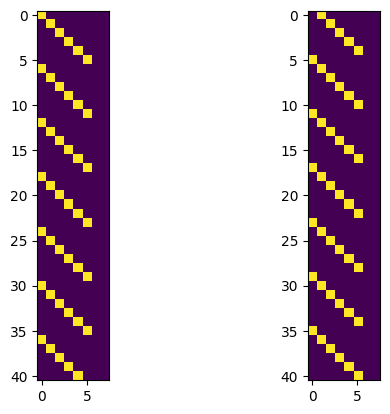

In [65]:
def generateIOData(songNr, songStrings=songStrings):
    songStrings = numpy.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

    notes=list("ABCDEFGH")
    I = np.zeros((41, 8))
    O = np.zeros(41, dtype=int)  # Now preparing O as indices directly
    raw =numpy.zeros((41,8)) # Now preparing O as indices directly
    for i in range(41):
        note_index = notes.index(songStrings[songNr][i])
        I[i][note_index] = 1.0
        raw[i][notes.index(songStrings[songNr][i+1])]=1.0
        if i < 40:  # Adjusting for O to capture the next note as index
            O[i] = notes.index(songStrings[songNr][i + 1])
    return I, O, raw

I,O, raw=generateIOData(1)
print(I.shape,O.shape)
print(I[0],O)
subplot(1,2,1)
imshow(I)
subplot(1,2,2)
imshow(raw)

In [47]:
model = SimpleRNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 2000
number_of_Songs = 4
songs = list(range(number_of_Songs))
L = []
A = []
for epoch in range(num_epochs):
    np.random.shuffle(songs)
    lo=numpy.zeros((number_of_Songs))
    acc=numpy.zeros((number_of_Songs))
    total_loss = 0
    total_accuracy = 0
    for song in songs:
        I, O, raw = generateIOData(song)
        inputs = torch.tensor(I, dtype=torch.float).unsqueeze(0)  # Add batch dimension
        targets = torch.tensor(O, dtype=torch.long)  # Targets are now indices

        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 8), targets)  # Reshape for CrossEntropyLoss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted_indices = torch.max(outputs, 2)
        accuracy = (predicted_indices.squeeze() == targets).float().mean().item()
        acc[song] = accuracy
        total_accuracy += accuracy
        lo[song]=loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss / number_of_Songs}, Accuracy: {total_accuracy / number_of_Songs}')
        print(f'Epoch {epoch+1}, Loss: {mean(lo)}, Losses: {numpy.round(lo,2)}')
        print(f'Epoch {epoch+1}, Accuracy: {mean(acc)}, Accuracies: {numpy.round(acc,2)}')
        
    L.append(total_loss / number_of_Songs)
    A.append(total_accuracy / number_of_Songs)
    
    if len(A)>= 2000 or total_accuracy / number_of_Songs >0.97:
      break
  
  
  


Epoch 1, Loss: 2.0876846313476562, Accuracy: 0.19512195140123367
Epoch 1, Loss: 2.0876846313476562, Losses: [2.07 2.07 2.15 2.06]
Epoch 1, Accuracy: 0.19512195140123367, Accuracies: [0.12 0.34 0.12 0.2 ]
Epoch 11, Loss: 1.9403018951416016, Accuracy: 0.2560975644737482
Epoch 11, Loss: 1.9403018951416016, Losses: [2.02 1.9  1.91 1.94]
Epoch 11, Accuracy: 0.2560975644737482, Accuracies: [0.07 0.49 0.22 0.24]
Epoch 21, Loss: 1.8889248967170715, Accuracy: 0.3048780560493469
Epoch 21, Loss: 1.8889248967170715, Losses: [2.01 1.8  1.86 1.88]
Epoch 21, Accuracy: 0.3048780560493469, Accuracies: [0.27 0.49 0.24 0.22]
Epoch 31, Loss: 1.8377523124217987, Accuracy: 0.3231707289814949
Epoch 31, Loss: 1.8377523124217987, Losses: [1.99 1.69 1.83 1.85]
Epoch 31, Accuracy: 0.3231707289814949, Accuracies: [0.1  0.63 0.32 0.24]
Epoch 41, Loss: 1.7383893430233002, Accuracy: 0.45121951401233673
Epoch 41, Loss: 1.7383893430233002, Losses: [1.88 1.45 1.8  1.82]
Epoch 41, Accuracy: 0.45121951401233673, Accuraci

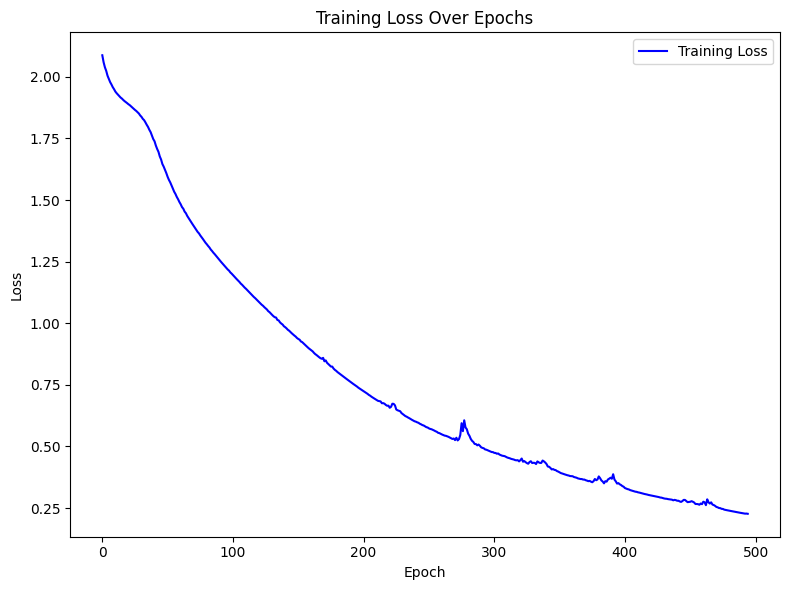

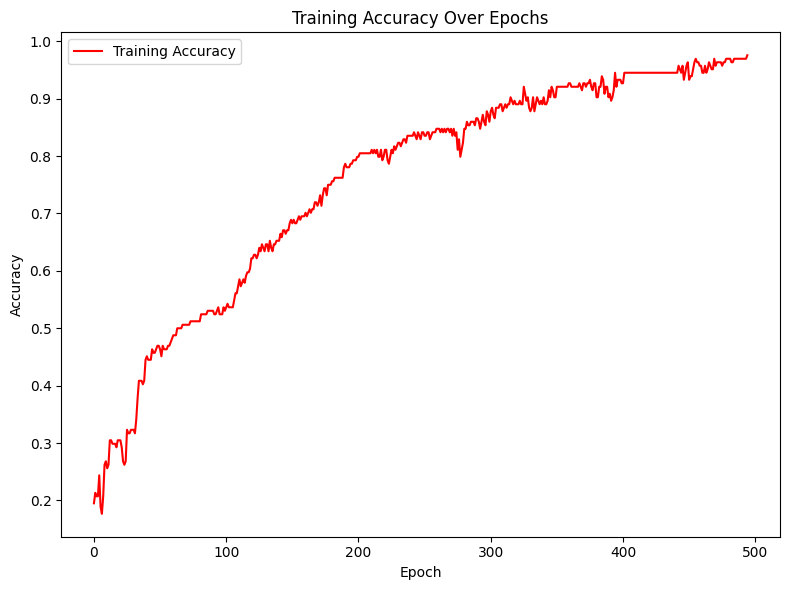

In [48]:
# Plot for Loss
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(L, label='Training Loss', color='blue')  # Plot loss with a label
plt.title('Training Loss Over Epochs')  # Title of the plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.grid(False)  # Add grid lines for better readability
plt.legend()  # Show legend to identify the line plot
plt.tight_layout()  # Adjust the layout to make room for the elements
plt.show()  # Display the plot

# Plot for Accuracy
plt.figure(figsize=(8, 6))  # Set figure size for the accuracy plot
plt.plot(A, label='Training Accuracy', color='red')  # Plot accuracy with a label
plt.title('Training Accuracy Over Epochs')  # Title of the plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.grid(False)  # Add grid lines for better readability
plt.legend()  # Show legend
plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plot

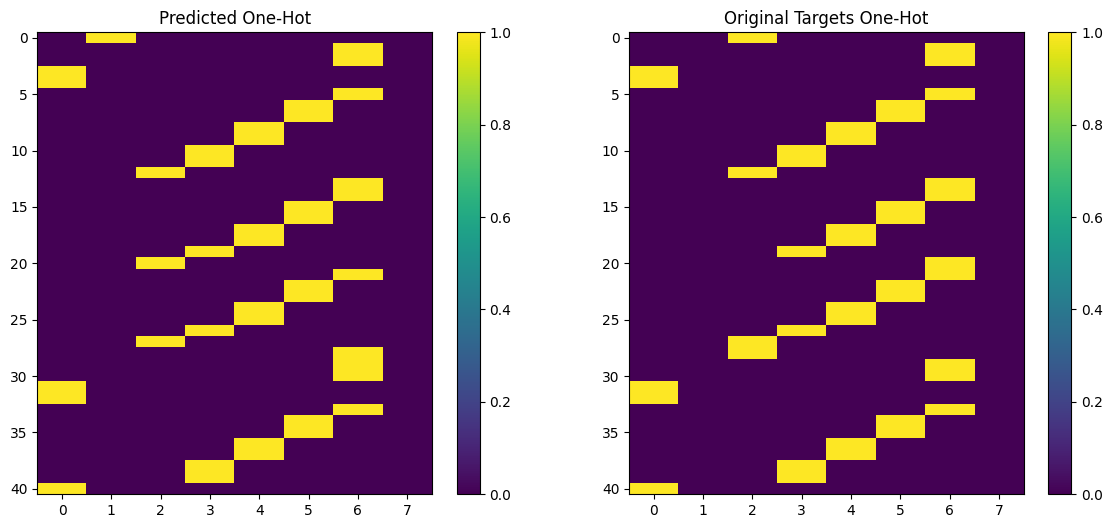

In [49]:
I, O, raw  = generateIOData(0) 

inputs = torch.Tensor(I).unsqueeze(0)  
outputs = model(inputs)

_, predicted_indices = torch.max(outputs, 2)

num_classes = 8 

predicted_one_hot = F.one_hot(predicted_indices.squeeze(), num_classes=num_classes).numpy()


O_tensor = torch.tensor(O, dtype=torch.long)
original_one_hot = F.one_hot(O_tensor, num_classes=num_classes).numpy()


plt.figure(figsize=(14, 6))

# Plotting one-hot encoded predicted indices
plt.subplot(1, 2, 1)
plt.imshow(predicted_one_hot, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Predicted One-Hot')

# Plotting one-hot encoded original targets
plt.subplot(1, 2, 2)
plt.imshow(original_one_hot, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Original Targets One-Hot')

plt.show()

In [58]:
class RNN(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


In [51]:
model = RNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 2000
number_of_Songs = 4
songs = list(range(number_of_Songs))
L = []
A = []
for epoch in range(num_epochs):
    np.random.shuffle(songs)
    lo=numpy.zeros((number_of_Songs))
    acc=numpy.zeros((number_of_Songs))
    total_loss = 0
    total_accuracy = 0
    for song in songs:
        I, O, raw = generateIOData(song)
        inputs = torch.tensor(I, dtype=torch.float).unsqueeze(0)  # Add batch dimension
        targets = torch.tensor(O, dtype=torch.long)  # Targets are now indices

        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 8), targets)  # Reshape for CrossEntropyLoss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted_indices = torch.max(outputs, 2)
        accuracy = (predicted_indices.squeeze() == targets).float().mean().item()
        acc[song] = accuracy
        total_accuracy += accuracy
        lo[song]=loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss / number_of_Songs}, Accuracy: {total_accuracy / number_of_Songs}')
        print(f'Epoch {epoch+1}, Loss: {mean(lo)}, Losses: {numpy.round(lo,2)}')
        print(f'Epoch {epoch+1}, Accuracy: {mean(acc)}, Accuracies: {numpy.round(acc,2)}')
        
    L.append(total_loss / number_of_Songs)
    A.append(total_accuracy / number_of_Songs)
    
    if len(A)>= 2000 or total_accuracy / number_of_Songs >0.97:
      break


Epoch 1, Loss: 2.1134721636772156, Accuracy: 0.0
Epoch 1, Loss: 2.1134721636772156, Losses: [2.15 2.12 2.1  2.1 ]
Epoch 1, Accuracy: 0.0, Accuracies: [0. 0. 0. 0.]
Epoch 11, Loss: 1.9713633954524994, Accuracy: 0.16463414207100868
Epoch 11, Loss: 1.9713633954524994, Losses: [2.06 1.95 1.92 1.95]
Epoch 11, Accuracy: 0.16463414207100868, Accuracies: [0.22 0.15 0.1  0.2 ]
Epoch 21, Loss: 1.9031897485256195, Accuracy: 0.22560975514352322
Epoch 21, Loss: 1.9031897485256195, Losses: [2.03 1.85 1.85 1.89]
Epoch 21, Accuracy: 0.22560975514352322, Accuracies: [0.37 0.29 0.17 0.07]
Epoch 31, Loss: 1.8429174721240997, Accuracy: 0.24390243366360664
Epoch 31, Loss: 1.8429174721240997, Losses: [1.95 1.76 1.81 1.86]
Epoch 31, Accuracy: 0.24390243366360664, Accuracies: [0.39 0.2  0.17 0.22]
Epoch 41, Loss: 1.7287963032722473, Accuracy: 0.42073170840740204
Epoch 41, Loss: 1.7287963032722473, Losses: [1.79 1.54 1.77 1.82]
Epoch 41, Accuracy: 0.42073170840740204, Accuracies: [0.59 0.49 0.34 0.27]
Epoch 51

In [59]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [61]:
class RNNA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(RNNA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp)  

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        
        attn_out = self.attention(x)
        
        expanded_attn_out = self.expand_layer(attn_out)
        
        expanded_attn_out = torch.relu(expanded_attn_out)

        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        
        rnn_out, self.hidden = self.rnnLayer(expanded_attn_out, h0)
    
        out = self.outputLayer(rnn_out)

        return out
    
    

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


In [54]:
model = RNNA()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 2000
number_of_Songs = 4
songs = list(range(number_of_Songs))
L = []
A = []
for epoch in range(num_epochs):
    np.random.shuffle(songs)
    lo=numpy.zeros((number_of_Songs))
    acc=numpy.zeros((number_of_Songs))
    total_loss = 0
    total_accuracy = 0
    for song in songs:
        I, O, raw = generateIOData(song)
        inputs = torch.tensor(I, dtype=torch.float).unsqueeze(0)  # Add batch dimension
        targets = torch.tensor(O, dtype=torch.long)  # Targets are now indices

        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 8), targets)  # Reshape for CrossEntropyLoss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted_indices = torch.max(outputs, 2)
        accuracy = (predicted_indices.squeeze() == targets).float().mean().item()
        acc[song] = accuracy
        total_accuracy += accuracy
        lo[song]=loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss / number_of_Songs}, Accuracy: {total_accuracy / number_of_Songs}')
        print(f'Epoch {epoch+1}, Loss: {mean(lo)}, Losses: {numpy.round(lo,2)}')
        print(f'Epoch {epoch+1}, Accuracy: {mean(acc)}, Accuracies: {numpy.round(acc,2)}')
        
    L.append(total_loss / number_of_Songs)
    A.append(total_accuracy / number_of_Songs)
    
    if len(A)>= 2000 or total_accuracy / number_of_Songs >0.97:
      break


Epoch 1, Loss: 2.1563318371772766, Accuracy: 0.1341463401913643
Epoch 1, Loss: 2.1563318371772766, Losses: [2.16 2.15 2.18 2.14]
Epoch 1, Accuracy: 0.1341463401913643, Accuracies: [0.   0.17 0.17 0.2 ]


Epoch 11, Loss: 1.9814650416374207, Accuracy: 0.19512195140123367
Epoch 11, Loss: 1.9814650416374207, Losses: [2.07 1.96 1.94 1.95]
Epoch 11, Accuracy: 0.19512195140123367, Accuracies: [0.12 0.2  0.34 0.12]
Epoch 21, Loss: 1.9217222034931183, Accuracy: 0.18292682617902756
Epoch 21, Loss: 1.9217222034931183, Losses: [2.07 1.88 1.85 1.88]
Epoch 21, Accuracy: 0.18292682617902756, Accuracies: [0.12 0.2  0.32 0.1 ]
Epoch 31, Loss: 1.907640516757965, Accuracy: 0.23170732334256172
Epoch 31, Loss: 1.907640516757965, Losses: [2.08 1.86 1.84 1.85]
Epoch 31, Accuracy: 0.23170732334256172, Accuracies: [0.24 0.17 0.27 0.24]
Epoch 41, Loss: 1.8990378379821777, Accuracy: 0.23170731589198112
Epoch 41, Loss: 1.8990378379821777, Losses: [2.06 1.86 1.83 1.85]
Epoch 41, Accuracy: 0.23170731589198112, Accuracies: [0.24 0.2  0.34 0.15]
Epoch 51, Loss: 1.8888558149337769, Accuracy: 0.25
Epoch 51, Loss: 1.8888558149337769, Losses: [2.03 1.85 1.83 1.84]
Epoch 51, Accuracy: 0.25, Accuracies: [0.24 0.2  0.29 0.2

In [62]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        self.outputLayer = nn.Linear(int(self.hidden_dim/2), self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)), torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        out, self.h0 = self.lstmLayer(x, self.h0)

        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)

        out = self.outputLayer(out)
        return out

        
    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    


In [56]:
model = LSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 2000
number_of_Songs = 4
songs = list(range(number_of_Songs))
L = []
A = []
for epoch in range(num_epochs):
    np.random.shuffle(songs)
    lo=numpy.zeros((number_of_Songs))
    acc=numpy.zeros((number_of_Songs))
    total_loss = 0
    total_accuracy = 0
    for song in songs:
        I, O, raw = generateIOData(song)
        inputs = torch.tensor(I, dtype=torch.float).unsqueeze(0)  
        targets = torch.tensor(O, dtype=torch.long)  
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 8), targets)  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted_indices = torch.max(outputs, 2)
        accuracy = (predicted_indices.squeeze() == targets).float().mean().item()
        acc[song] = accuracy
        total_accuracy += accuracy
        lo[song]=loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss / number_of_Songs}, Accuracy: {total_accuracy / number_of_Songs}')
        print(f'Epoch {epoch+1}, Loss: {mean(lo)}, Losses: {numpy.round(lo,2)}')
        print(f'Epoch {epoch+1}, Accuracy: {mean(acc)}, Accuracies: {numpy.round(acc,2)}')
        
    L.append(total_loss / number_of_Songs)
    A.append(total_accuracy / number_of_Songs)
    
    if len(A)>= 2000 or total_accuracy / number_of_Songs >0.97:
      break


Epoch 1, Loss: 2.054187059402466, Accuracy: 0.1463414616882801
Epoch 1, Loss: 2.054187059402466, Losses: [2.02 2.07 2.08 2.05]
Epoch 1, Accuracy: 0.1463414616882801, Accuracies: [0.1  0.15 0.12 0.22]
Epoch 11, Loss: 2.0216087698936462, Accuracy: 0.18292682617902756
Epoch 11, Loss: 2.0216087698936462, Losses: [2.   2.03 2.05 2.01]
Epoch 11, Accuracy: 0.18292682617902756, Accuracies: [0.05 0.32 0.15 0.22]
Epoch 21, Loss: 1.9714930951595306, Accuracy: 0.17073170468211174
Epoch 21, Loss: 1.9714930951595306, Losses: [2.   1.95 2.   1.94]
Epoch 21, Accuracy: 0.17073170468211174, Accuracies: [0.2  0.17 0.15 0.17]
Epoch 31, Loss: 1.9136067032814026, Accuracy: 0.18902438506484032
Epoch 31, Loss: 1.9136067032814026, Losses: [1.99 1.88 1.91 1.88]
Epoch 31, Accuracy: 0.18902438506484032, Accuracies: [0.2  0.2  0.15 0.22]
Epoch 41, Loss: 1.8699820637702942, Accuracy: 0.2682926803827286
Epoch 41, Loss: 1.8699820637702942, Losses: [1.97 1.81 1.84 1.86]
Epoch 41, Accuracy: 0.2682926803827286, Accuraci

In [63]:
class LSTMA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(LSTMA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp)  

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        self.outputLayer = nn.Linear(int(self.hidden_dim/2), self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        
        attn_out = self.attention(x)

        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.relu(expanded_attn_out)

        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        lstm_out, _ = self.lstmLayer(expanded_attn_out, h0)
        
        out = self.outputLayer(lstm_out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    


In [58]:
model = LSTMA()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 2000
number_of_Songs = 4
songs = list(range(number_of_Songs))
L = []
A = []
for epoch in range(num_epochs):
    np.random.shuffle(songs)
    lo=numpy.zeros((number_of_Songs))
    acc=numpy.zeros((number_of_Songs))
    total_loss = 0
    total_accuracy = 0
    for song in songs:
        I, O, raw = generateIOData(song)
        inputs = torch.tensor(I, dtype=torch.float).unsqueeze(0)  # Add batch dimension
        targets = torch.tensor(O, dtype=torch.long)  # Targets are now indices

        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 8), targets)  # Reshape for CrossEntropyLoss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted_indices = torch.max(outputs, 2)
        accuracy = (predicted_indices.squeeze() == targets).float().mean().item()
        acc[song] = accuracy
        total_accuracy += accuracy
        lo[song]=loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss / number_of_Songs}, Accuracy: {total_accuracy / number_of_Songs}')
        print(f'Epoch {epoch+1}, Loss: {mean(lo)}, Losses: {numpy.round(lo,2)}')
        print(f'Epoch {epoch+1}, Accuracy: {mean(acc)}, Accuracies: {numpy.round(acc,2)}')
        
    L.append(total_loss / number_of_Songs)
    A.append(total_accuracy / number_of_Songs)
    
    if len(A)>= 2000 or total_accuracy / number_of_Songs >0.97:
      break


Epoch 1, Loss: 2.108505964279175, Accuracy: 0.1768292672932148
Epoch 1, Loss: 2.108505964279175, Losses: [2.08 2.11 2.06 2.18]
Epoch 1, Accuracy: 0.1768292672932148, Accuracies: [0.12 0.17 0.32 0.1 ]
Epoch 11, Loss: 2.0428624749183655, Accuracy: 0.18902438506484032
Epoch 11, Loss: 2.0428624749183655, Losses: [2.04 2.04 2.01 2.09]
Epoch 11, Accuracy: 0.18902438506484032, Accuracies: [0.22 0.15 0.2  0.2 ]
Epoch 21, Loss: 1.9722120761871338, Accuracy: 0.1768292672932148
Epoch 21, Loss: 1.9722120761871338, Losses: [2.01 1.96 1.94 1.98]
Epoch 21, Accuracy: 0.1768292672932148, Accuracies: [0.2  0.17 0.17 0.17]
Epoch 31, Loss: 1.9322581589221954, Accuracy: 0.18902438506484032
Epoch 31, Loss: 1.9322581589221954, Losses: [2.02 1.91 1.9  1.9 ]
Epoch 31, Accuracy: 0.18902438506484032, Accuracies: [0.22 0.15 0.2  0.2 ]
Epoch 41, Loss: 1.9191141426563263, Accuracy: 0.18902438879013062
Epoch 41, Loss: 1.9191141426563263, Losses: [2.04 1.89 1.87 1.88]
Epoch 41, Accuracy: 0.18902438879013062, Accuraci

In [64]:
class GRU(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.GRULayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.GRULayer(x, self.h0)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.GRULayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


In [60]:
model = GRU()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 2000
number_of_Songs = 4
songs = list(range(number_of_Songs))
L = []
A = []
for epoch in range(num_epochs):
    np.random.shuffle(songs)
    lo=numpy.zeros((number_of_Songs))
    acc=numpy.zeros((number_of_Songs))
    total_loss = 0
    total_accuracy = 0
    for song in songs:
        I, O, raw = generateIOData(song)
        inputs = torch.tensor(I, dtype=torch.float).unsqueeze(0)  # Add batch dimension
        targets = torch.tensor(O, dtype=torch.long)  # Targets are now indices

        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 8), targets)  # Reshape for CrossEntropyLoss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted_indices = torch.max(outputs, 2)
        accuracy = (predicted_indices.squeeze() == targets).float().mean().item()
        acc[song] = accuracy
        total_accuracy += accuracy
        lo[song]=loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss / number_of_Songs}, Accuracy: {total_accuracy / number_of_Songs}')
        print(f'Epoch {epoch+1}, Loss: {mean(lo)}, Losses: {numpy.round(lo,2)}')
        print(f'Epoch {epoch+1}, Accuracy: {mean(acc)}, Accuracies: {numpy.round(acc,2)}')
        
    L.append(total_loss / number_of_Songs)
    A.append(total_accuracy / number_of_Songs)
    
    if len(A)>= 2000 or total_accuracy / number_of_Songs >0.97:
      break


Epoch 1, Loss: 2.0639363527297974, Accuracy: 0.1768292672932148
Epoch 1, Loss: 2.0639363527297974, Losses: [2.07 2.06 2.07 2.06]
Epoch 1, Accuracy: 0.1768292672932148, Accuracies: [0.22 0.17 0.15 0.17]


Epoch 11, Loss: 1.984323114156723, Accuracy: 0.17073170468211174
Epoch 11, Loss: 1.984323114156723, Losses: [2.04 1.97 1.96 1.97]
Epoch 11, Accuracy: 0.17073170468211174, Accuracies: [0.2  0.17 0.15 0.17]
Epoch 21, Loss: 1.9167703986167908, Accuracy: 0.27439023554325104
Epoch 21, Loss: 1.9167703986167908, Losses: [2.02 1.88 1.87 1.89]
Epoch 21, Accuracy: 0.27439023554325104, Accuracies: [0.32 0.29 0.2  0.29]
Epoch 31, Loss: 1.8784328401088715, Accuracy: 0.2804878056049347
Epoch 31, Loss: 1.8784328401088715, Losses: [2.03 1.81 1.82 1.85]
Epoch 31, Accuracy: 0.2804878056049347, Accuracies: [0.24 0.34 0.24 0.29]
Epoch 41, Loss: 1.8368586897850037, Accuracy: 0.2804878056049347
Epoch 41, Loss: 1.8368586897850037, Losses: [2.   1.73 1.78 1.83]
Epoch 41, Accuracy: 0.2804878056049347, Accuracies: [0.22 0.34 0.27 0.29]
Epoch 51, Loss: 1.7683805227279663, Accuracy: 0.3658536598086357
Epoch 51, Loss: 1.7683805227279663, Losses: [1.93 1.61 1.72 1.82]
Epoch 51, Accuracy: 0.3658536598086357, Accurac

In [65]:
class GRUA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(GRUA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp) 
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        attn_out = self.attention(x)

        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.relu(expanded_attn_out)

        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
    
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

    
                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)



In [62]:
model = GRUA()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 2000
number_of_Songs = 4
songs = list(range(number_of_Songs))
L = []
A = []
for epoch in range(num_epochs):
    np.random.shuffle(songs)
    lo=numpy.zeros((number_of_Songs))
    acc=numpy.zeros((number_of_Songs))
    total_loss = 0
    total_accuracy = 0
    for song in songs:
        I, O, raw = generateIOData(song)
        inputs = torch.tensor(I, dtype=torch.float).unsqueeze(0)  
        targets = torch.tensor(O, dtype=torch.long) 

        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 8), targets)  #
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted_indices = torch.max(outputs, 2)
        accuracy = (predicted_indices.squeeze() == targets).float().mean().item()
        acc[song] = accuracy
        total_accuracy += accuracy
        lo[song]=loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss / number_of_Songs}, Accuracy: {total_accuracy / number_of_Songs}')
        print(f'Epoch {epoch+1}, Loss: {mean(lo)}, Losses: {numpy.round(lo,2)}')
        print(f'Epoch {epoch+1}, Accuracy: {mean(acc)}, Accuracies: {numpy.round(acc,2)}')
        
    L.append(total_loss / number_of_Songs)
    A.append(total_accuracy / number_of_Songs)
    
    if len(A)>= 2000 or total_accuracy / number_of_Songs >0.97:
      break


Epoch 1, Loss: 2.076264441013336, Accuracy: 0.18902438879013062
Epoch 1, Loss: 2.076264441013336, Losses: [2.15 2.06 2.02 2.07]
Epoch 1, Accuracy: 0.18902438879013062, Accuracies: [0.12 0.2  0.34 0.1 ]
Epoch 11, Loss: 2.000203102827072, Accuracy: 0.1768292672932148
Epoch 11, Loss: 2.000203102827072, Losses: [2.08 1.99 1.95 1.99]
Epoch 11, Accuracy: 0.1768292672932148, Accuracies: [0.12 0.17 0.32 0.1 ]
Epoch 21, Loss: 1.9321596026420593, Accuracy: 0.19512195512652397
Epoch 21, Loss: 1.9321596026420593, Losses: [2.05 1.9  1.88 1.9 ]
Epoch 21, Accuracy: 0.19512195512652397, Accuracies: [0.24 0.12 0.17 0.24]
Epoch 31, Loss: 1.9111737310886383, Accuracy: 0.20121951028704643
Epoch 31, Loss: 1.9111737310886383, Losses: [2.07 1.87 1.85 1.86]
Epoch 31, Accuracy: 0.20121951028704643, Accuracies: [0.24 0.15 0.2  0.22]
Epoch 41, Loss: 1.9017472565174103, Accuracy: 0.19512194767594337
Epoch 41, Loss: 1.9017472565174103, Losses: [2.06 1.86 1.83 1.85]
Epoch 41, Accuracy: 0.19512194767594337, Accuraci

In [86]:
def symbolEntropy(D, base=2):
    value, counts = numpy.unique(D, return_counts=True)  # Find unique values and their frequency in D
    return entropy(counts, base=base)  # Calculate and return the Shannon entropy

# This function seems to compute a complex metric, possibly related to information theory, involving inputs I, hidden states H, and outputs O.
def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    # Create various combinations of Inputs (I), Hidden states (H), and Outputs (O) for analysis
    # B, IB, AB, BO, IAB, IBO, ABO, IABO are different combinations of I, H, and O
    # Calculate entropy for each combination using symbolEntropy
    # Return a specific information metric combining these entropies


    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

# This function seems to analyze how information is processed or transmitted through a network, focusing on individual components (nodes) of the hidden states H.
def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes = list(range(width))  # Initialize a list of node indices
    cols = []  # To store subsets of nodes
    colh = []  # To store corresponding information values
    # Iteratively remove a node, compute information value, and record subsets and values
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh


# This function processes the output of a model given a dataset. It appears to involve some form of clustering (using KMeans) and then re-encoding the hidden states H.
def getOutTaH(model,dataSet):
    O, H = model.step(torch.Tensor(dataSet))  # Get output and hidden states from the model
    # Transform H using clustering and re-encoding

    #print(H.shape,H.min(),H.max())
    #figure()
    #hist(H.flatten())

    H = H.transpose()  # Transpose H for processing
    O = O.transpose()  # Transpose O for processing
    B = numpy.zeros(H.shape)  # Initialize a matrix to store cluster labels for each hidden state
    # Apply KMeans clustering to each hidden state
    # Recompute H as a combination of cluster labels (B)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        x =len(numpy.unique(a))
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

# This function seems to integrate the previous functions to analyze how information flows through the network for different input-output pairs in a dataset.
def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5,dsLength=8):
    output, H = getOutTaH(model, dataSet)  # Get transformed outputs and hidden states from the model
    # Slice output and H to process only specific timesteps
    output=output.transpose()[whichTS::dsLength].transpose()

    #print("target.shape",target.shape,"output.shape",output.shape,"H.shape",H.shape,"dataset.shape",dataSet.shape)
    H=H.transpose()[whichTS::dsLength].transpose()
    #target=target.transpose()[whichTS::dsLength].transpose()
    #print(H.shape,target.shape,numpy.array(range(512))[whichTS::dsLength])

    collectorSet = dict()  # To store information about subsets of nodes (S)
    collectorH = dict()    # To store information values (H)
    # Compute shrinking decomposition information for selected inputs/outputs
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        #print(number,"I.shape",I.shape,"O.shape",O.shape,"H.shape",H.shape)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH


# These functions convert the results of the shrinking decomposition into vector and matrix forms, which are likely used for further analysis or visualization.
def removalIntoVec(res,width,H):
    # Convert the shrinking decomposition results into a vector form

    V = numpy.zeros(width)  # Initialize a vector
    # Calculate values for V based on the difference in information values (H) as nodes are removed
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)

    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]

    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    # Convert the shrinking decomposition results into a matrix form

    M=[]
    # Convert the shrinking decomposition results (S and H) into a matrix form
    # This matrix can be used for visualization or further analysis
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

In [64]:
def train_model(model, num_epochs, number_of_Songs):
    L = []
    A = []
    songs = list(range(number_of_Songs))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(num_epochs):
        np.random.shuffle(songs)
        lo = np.zeros((number_of_Songs))
        acc = np.zeros((number_of_Songs))
        total_loss = 0
        total_accuracy = 0
        for i, song in enumerate(songs):
            I, O, raw = generateIOData(song)
            inputs = torch.tensor(I, dtype=torch.float).unsqueeze(0)  # Add batch dimension
            targets = torch.tensor(O, dtype=torch.long)  # Targets are now indices

            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 8), targets)  # Reshape for CrossEntropyLoss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            _, predicted_indices = torch.max(outputs, 2)
            accuracy = (predicted_indices.squeeze() == targets).float().mean().item()
            acc[i] = accuracy
            total_accuracy += accuracy
            lo[i] = loss.item()
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {total_loss / number_of_Songs}, Accuracy: {total_accuracy / number_of_Songs}')
            print(f'Epoch {epoch+1}, Loss: {np.mean(lo)}, Losses: {np.round(lo,2)}')
            print(f'Epoch {epoch+1}, Accuracy: {np.mean(acc)}, Accuracies: {np.round(acc,2)}')
            
        L.append(total_loss / number_of_Songs)
        A.append(total_accuracy / number_of_Songs)
        
        if len(A) >= 2000 or total_accuracy / number_of_Songs > 0.97:
            break
    return L, A

In [32]:
class GRU(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.GRULayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose=False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.GRULayer(x, self.h0)
        #self.store = (copy.deepcopy(self.h0.detach().numpy()))
        self.store= self.h0.detach().numpy().copy()

        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            step_input = self.expand_layer(x[l].reshape((1, 1, self.inp)))
            step_input = torch.relu(step_input)
            out, h0 = self.GRULayer(step_input, h0)
            H.append(out.detach().numpy().flatten())
            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
       
        return numpy.array(O), numpy.array(H)


In [212]:
model = GRU()
num_epochs = 2000
number_of_Songs = 4
A, L  = train_model(model, num_epochs, number_of_Songs)

Epoch 1, Loss: 2.064744710922241, Accuracy: 0.1768292672932148
Epoch 1, Loss: 2.064744710922241, Losses: [2.07 2.09 2.05 2.05]
Epoch 1, Accuracy: 0.1768292672932148, Accuracies: [0.32 0.05 0.12 0.22]
Epoch 11, Loss: 1.9811216294765472, Accuracy: 0.20121951401233673
Epoch 11, Loss: 1.9811216294765472, Losses: [1.97 1.95 1.96 2.05]
Epoch 11, Accuracy: 0.20121951401233673, Accuracies: [0.17 0.24 0.17 0.22]
Epoch 21, Loss: 1.9162100851535797, Accuracy: 0.2073170766234398
Epoch 21, Loss: 1.9162100851535797, Losses: [2.04 1.88 1.87 1.88]
Epoch 21, Accuracy: 0.2073170766234398, Accuracies: [0.22 0.27 0.17 0.17]
Epoch 31, Loss: 1.8681224882602692, Accuracy: 0.2195121943950653
Epoch 31, Loss: 1.8681224882602692, Losses: [1.84 1.82 1.77 2.05]
Epoch 31, Accuracy: 0.2195121943950653, Accuracies: [0.22 0.2  0.2  0.27]
Epoch 41, Loss: 1.8135305047035217, Accuracy: 0.40243902057409286
Epoch 41, Loss: 1.8135305047035217, Losses: [1.77 1.65 1.8  2.02]
Epoch 41, Accuracy: 0.40243902057409286, Accuracies

In [189]:
s,t, raw=generateIOData(4)


In [179]:
s.shape

(41, 8)

{0: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [11, 12, 13, 14, 15, 16, 17, 18, 19], [12, 13, 14, 15, 16, 17, 18, 19], [13, 14, 15, 16, 17, 18, 19], [14, 15, 16, 17, 18, 19], [15, 16, 17, 18, 19], [16, 17, 18, 19], [17, 18, 19], [18, 19], [19], []], 1: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 

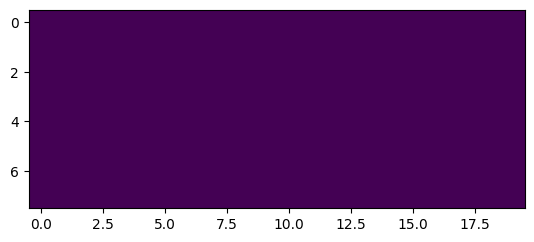

In [213]:
s,t, raw=generateIOData(4)
S,H=shrinkingDecompositionInformation(model,20,s,t.transpose(),numbers=[0,1,2,3,4,5,6,7],whichTS=40,dsLength=41)
M=removalIntoMatrix(S,20,H)
imshow(M)
print(S)
print(H)

In [226]:
def predict_next_token(model, token_indices,verbose=False):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Convert the list of token indices to a PyTorch tensor and add a batch dimension
    src = torch.tensor(token_indices, dtype=torch.long).unsqueeze(1)  # Shape [sequence_length, 1] to match expected input

    with torch.no_grad():
        output = model(src)  # Get model output for the entire sequence

    # Assuming output is [sequence_length, 1, ntokens] and we're interested in the last token's prediction
    last_token_logits = output[-1, 0, :]  # Get logits for the last token
    predicted_token_index = last_token_logits.argmax().item()  # Find the index of the max log-probability
    
    return predicted_token_index

# Example usage:
# Assuming you have a `model` instance and a sentence represented as a list of token indices
# token_indices = [1, 2, 3, 2, 1, 2, 3, ...]
who=34
predicted_token_index = predict_next_token(model, source[who],verbose=True)
print(f'Predicted next token index: {predicted_token_index}')
print(target[who][-1])

Predicted next token index: 1


In [ ]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def getAllIOH(model,source,target,songs,width=20):
    I=[]
    O=[]
    H=[]
    for i in range(len(songs)):
        I.append(songs[i])
        predicted_token_index = predict_next_token(model, source[i])
        if predicted_token_index==target[i][-1]:
            O.append(songs[i])
        else:
            O.append((songs[i]+1)%max(songs))
        H.append(list(model.store[-1].flatten()))
    H=numpy.array(H).transpose()
    print(H.shape)
    imshow(H)
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
    print(B.shape)
    H=numpy.zeros((H.shape[1]))
    for i in range(width):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return numpy.array(I),numpy.array(O),H

def shrinkingDecompositionInformation(model,source,target,songs,numbers=[0,1,2,3],width=20):
    allI,allO,H=getAllIOH(model,source,target,songs,width=width)
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=(1*(songs==number)).astype(int)
        O=(1*(allO==number)).astype(int)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

s,h=shrinkingDecompositionInformation(model,source,target,songs,numbers=list(range(5)),width=20)

Input shape: (533, 41, 8), Output shape: (533, 41, 8)


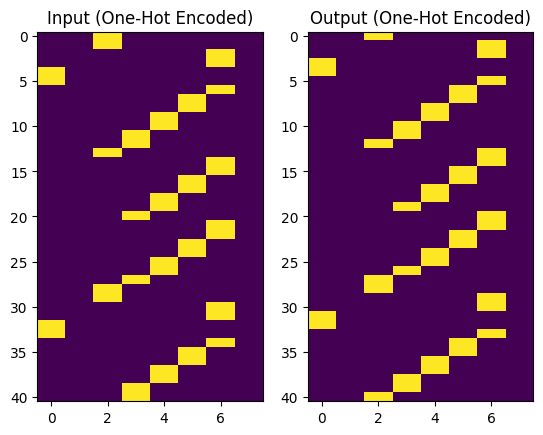

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generateIOData(songStrings):
    notes = list("ABCDEFGH")
    nrOfSongs = len(songStrings)
    source = []
    target = []
    raw_target = []
    for s in range(nrOfSongs):
        for i in range(len(songStrings[s]) - 1):  # Adjust for loop to cover up to the second last character
            input_one_hot = np.zeros((41, 8))
            target_one_hot = np.zeros((41, 8))  # Now preparing target as one-hot encoded vectors
            for j in range(41):
                if (i + j) < len(songStrings[s]):  # Ensure we don't exceed the song's length
                    input_index = notes.index(songStrings[s][(i+j) % len(songStrings[s])])
                    input_one_hot[j][input_index] = 1.0
                    if (i + j + 1) < len(songStrings[s]):
                        target_index = notes.index(songStrings[s][(i+j+1) % len(songStrings[s])])
                        target_one_hot[j][target_index] = 1.0
            source.append(input_one_hot)
            target.append(target_one_hot)
            raw_target.append(target_index)  # Keep track of the target indices
    return np.array(source), np.array(target), np.array(raw_target)

# Convert the songStrings to a numpy array if not already
songStrings = np.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

I, O, raw = generateIOData(songStrings)
print(f"Input shape: {I.shape}, Output shape: {O.shape}")

# Display the first input and raw output for visualization
plt.subplot(1, 2, 1)
plt.imshow(I[0], aspect='auto')
plt.title("Input (One-Hot Encoded)")
plt.subplot(1, 2, 2)
plt.imshow(O[0], aspect='auto')
plt.title("Output (One-Hot Encoded)")
plt.show()


In [9]:
print(raw)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 3 

Input shape: (42, 41, 8), Output (One-Hot) shape: (42, 41, 8), Output (Indices) shape: 42, Each output indices array length: 41


Text(0.5, 1.0, 'Output (One-Hot Encoded)')

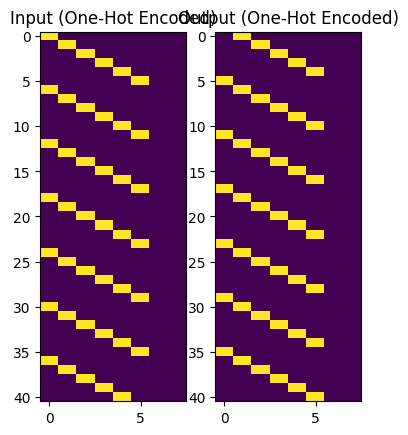

In [42]:
import numpy as np
import matplotlib.pyplot as plt

songStrings = numpy.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])


def generateIOData(songNr, songStrings):
    notes = list("ABCDEFGH")
    source = []
    target_one_hot = []
    target_indices = []
    
    songString = songStrings[songNr]
    
    # Ensure the loop considers the possibility of wrapping around the song's end for a continuous cycle
    for i in range(len(songString)):  # Allow wrapping to get a continuous sequence
        input_one_hot = np.zeros((41, 8))
        output_one_hot = np.zeros((41, 8))
        current_target_indices = []
        
        for j in range(41):  # Build each input window
            input_index = notes.index(songString[(i + j) % len(songString)])
            input_one_hot[j][input_index] = 1.0
            
            if (i + j + 1) < len(songString) + i:  # Wrap around to start for output
                next_char_index = notes.index(songString[(i + j + 1) % len(songString)])
                output_one_hot[j][next_char_index] = 1.0
                current_target_indices.append(next_char_index)
            else:
                current_target_indices.append(0)  # Append a placeholder if beyond song length

        source.append(input_one_hot)
        target_one_hot.append(output_one_hot)
        target_indices.append(current_target_indices)
        
    return np.array(source), np.array(target_one_hot), np.array(target_indices)

# Test the function with a specific song
songNr = 1  # Choose the second song for example
I, O_hot, O_indices = generateIOData(songNr, songStrings)

print(f"Input shape: {I.shape}, Output (One-Hot) shape: {O_hot.shape}, Output (Indices) shape: {len(O_indices)}, Each output indices array length: {len(O_indices[0])}")

# Display the first input and a portion of the output indices for visualization
plt.subplot(1, 3, 1)
plt.imshow(I[0], aspect='auto')
plt.title("Input (One-Hot Encoded)")

plt.subplot(1, 3, 2)
plt.imshow(O_hot[0], aspect='auto')
plt.title("Output (One-Hot Encoded)")




In [30]:
O_indices.shape

(42, 41)

In [72]:
def train_model(model, num_epochs, songStrings, number_of_Songs = 4):
    L = []
    A = []
    songs = list(range(number_of_Songs))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(num_epochs):
        np.random.shuffle(songs)
        total_loss = 0
        total_accuracy = 0
        lo = np.zeros((number_of_Songs))
        acc = np.zeros((number_of_Songs))
        for songNr, song in enumerate(songs):
            I, O_hot, O_indices = generateIOData(songNr, songStrings)
            
            # Prepare for shuffling
            combined = list(zip(I, O_indices))
            np.random.shuffle(combined)
            I_shuffled, O_indices_shuffled = zip(*combined)
            
            # Convert back to numpy arrays if necessary and then to tensors
            I_shuffled = np.array(I_shuffled)
            O_indices_shuffled = np.array(O_indices_shuffled)
            
            inputs = torch.tensor(I_shuffled, dtype=torch.float)  # Inputs are already in the correct shape
            targets = torch.tensor(O_indices_shuffled, dtype=torch.long)  # Use indices for CrossEntropyLoss
            

            # Assuming the model's output shape matches the targets shape
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 8), targets.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            _, predicted_indices = torch.max(outputs, -1)
            correct_predictions = predicted_indices == targets
            accuracy = correct_predictions.float().mean().item()
            acc[songNr] = accuracy
            total_accuracy += accuracy
            lo[songNr] = loss.item()
        avg_loss = total_loss / number_of_Songs
        avg_accuracy = total_accuracy / number_of_Songs

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')
            print(f'Epoch {epoch+1}, Loss: {np.mean(lo)}, Losses: {np.round(lo,2)}')
            print(f'Epoch {epoch+1}, Accuracy: {np.mean(acc)}, Accuracies: {np.round(acc,2)}')
        L.append(avg_loss)
        A.append(avg_accuracy)

        # Early stopping criteria (optional)
        if len(A) > 2000 or avg_accuracy > 0.97:
            print("Early stopping criteria met")
            break

    return L, A

In [131]:
model = RNN()
num_epochs = 3000
number_of_Songs = 4
A, L  = train_model(model, num_epochs, songStrings= songStrings, number_of_Songs = 4)

Epoch 1, Loss: 2.0855, Accuracy: 0.1208
Epoch 1, Loss: 2.0855168104171753, Losses: [2.05 2.11 2.09 2.1 ]
Epoch 1, Accuracy: 0.12078978307545185, Accuracies: [0.24 0.01 0.1  0.14]
Epoch 11, Loss: 1.9591, Accuracy: 0.2159
Epoch 11, Loss: 1.9591014087200165, Losses: [1.98 1.93 1.97 1.95]
Epoch 11, Accuracy: 0.21588269248604774, Accuracies: [0.28 0.17 0.21 0.19]
Epoch 21, Loss: 1.8879, Accuracy: 0.2766
Epoch 21, Loss: 1.8878759443759918, Losses: [2.   1.8  1.87 1.88]
Epoch 21, Accuracy: 0.2765679508447647, Accuracies: [0.19 0.33 0.24 0.35]
Epoch 31, Loss: 1.8069, Accuracy: 0.2940
Epoch 31, Loss: 1.806900829076767, Losses: [2.   1.55 1.8  1.87]
Epoch 31, Accuracy: 0.29398954287171364, Accuracies: [0.17 0.51 0.2  0.29]
Epoch 41, Loss: 1.7396, Accuracy: 0.3110
Epoch 41, Loss: 1.7395801842212677, Losses: [1.98 1.37 1.76 1.85]
Epoch 41, Accuracy: 0.3109756074845791, Accuracies: [0.24 0.52 0.2  0.29]
Epoch 51, Loss: 1.6734, Accuracy: 0.3622
Epoch 51, Loss: 1.6733735501766205, Losses: [1.92 1.22 

(8, 20)

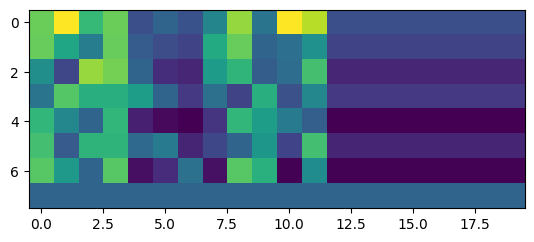

In [129]:
I, O_hot, O_indices = generateIOData(0, songStrings)

S,H=shrinkingDecompositionInformation(model,20,I,O_indices.transpose(),numbers=[0,1,2,3,4,5,6,7],whichTS=40,dsLength=41)
M=removalIntoMatrix(S,20,H)
imshow(M)
M.shape

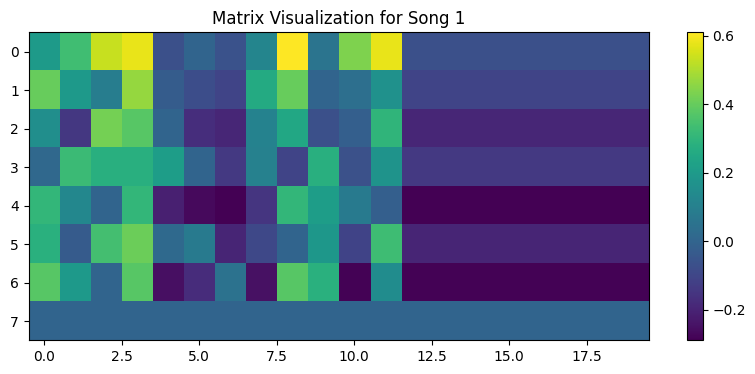

Shape of M for song 1: (8, 20)


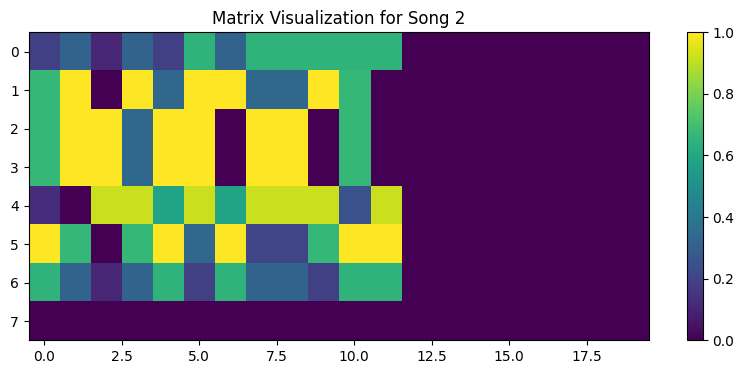

Shape of M for song 2: (8, 20)


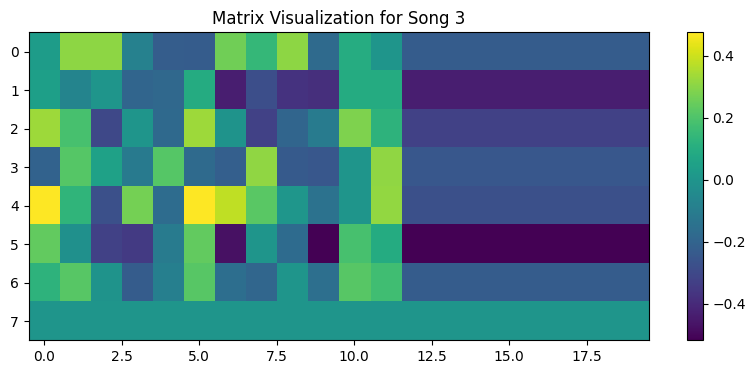

Shape of M for song 3: (8, 20)


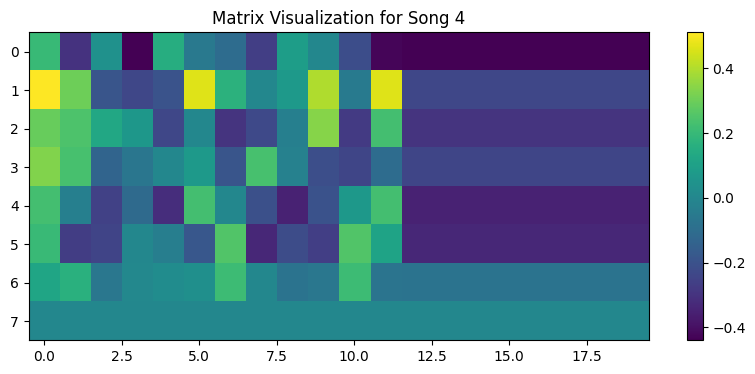

Shape of M for song 4: (8, 20)


In [130]:
import matplotlib.pyplot as plt

# Assuming the existence of generateIOData, shrinkingDecompositionInformation, and removalIntoMatrix functions.
for i in range(4):
    I, O_hot, O_indices = generateIOData(i, songStrings)
    
    # Assuming these functions return the necessary components for plotting
    S, H = shrinkingDecompositionInformation(model, 20, I, O_indices.transpose(), numbers=[0,1,2,3,4,5,6,7], whichTS=40, dsLength=41)
    M = removalIntoMatrix(S, 20, H)
    
    plt.figure(figsize=(10, 4))  # Adjust the figure size as necessary
    plt.imshow(M, aspect='auto')  # 'auto' can adjust the aspect ratio based on array dimensions
    plt.colorbar()  # Show color scale
    plt.title(f'Matrix Visualization for Song {i+1}')
    plt.show()

    print(f"Shape of M for song {i+1}: {M.shape}")